In [169]:
import pandas as pd
import seaborn as sns
import wandb
import os

# Results
Get results from Weights and Biases and produce plots for paper

In [170]:
def get_data_from_wandb():

    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs("messer/JavaDoc-Relevance-Binary-Classifier")

    summary_list, config_list, name_list, group_list, tag_list = [], [], [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        group_list.append(run.group)
        tag_list.append(run.tags)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "group": group_list,
        "tag": tag_list
    })

    runs_df.to_csv("data/training_results.csv")
    return runs_df

if not os.path.isfile("data/training_results.csv"):
    runs_df = get_data_from_wandb()

### Process WandB API call results

In [171]:
runs_df = pd.read_csv('data/training_results.csv')
runs_df['summary'] = runs_df['summary'].apply(lambda s: eval(s))
runs_df['config'] = runs_df['config'].apply(lambda s: eval(s))
runs_df.head()

,Unnamed: 0,summary,config,name,group,tag
0,0,"{'test/runtime': 0.9576, 'eval/precision_micro...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",whole-sea-1440,LORA:microsoft/codebert-base,"['no custom weights', 'preprocessed', 'rerun']"
1,1,"{'test/recall_micro': 0.8504672897196262, '_ru...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",lemon-elevator-1439,LORA:microsoft/codebert-base,"['no custom weights', 'preprocessed', 'rerun']"
2,2,"{'eval/accuracy': 1, 'train/train_loss': 0.000...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",colorful-bush-1438,LORA:microsoft/codebert-base,"['no custom weights', 'preprocessed', 'rerun']"
3,3,"{'_timestamp': 1706766412.9002829, 'train/epoc...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",eager-firebrand-1437,LORA:microsoft/codebert-base,"['no custom weights', 'preprocessed', 'rerun']"
4,4,"{'test/runtime': 0.9003, 'eval/f1_macro': 0.95...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",youthful-cosmos-1436,LORA:microsoft/codebert-base,"['no custom weights', 'preprocessed', 'rerun']"


In [172]:
df = pd.concat([runs_df[['name', 'group', 'config', 'tag']], pd.json_normalize(runs_df['summary'])], axis=1)

df.head()

,name,group,config,tag,test/runtime,eval/precision_micro,train/epoch,eval/runtime,test/f1_macro,eval/precision_macro,...,train/total_flos,test/recall_macro,train/train_runtime,eval/f1_macro,eval/f1_weighted,test/samples_per_second,_wandb.runtime,test/latency_in_seconds,test/total_time_in_seconds,split
0,whole-sea-1440,LORA:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['no custom weights', 'preprocessed', 'rerun']",0.9576,1.000000,100.0,0.4755,0.819229,1.000000,...,1.030667e+16,0.833150,823.5856,1.000000,1.000000,111.741,8240.0,NaN,NaN,NaN
1,lemon-elevator-1439,LORA:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['no custom weights', 'preprocessed', 'rerun']",0.8988,1.000000,10.0,0.3953,0.844683,1.000000,...,1.011248e+15,0.856250,85.8475,1.000000,1.000000,119.050,861.0,NaN,NaN,NaN
2,colorful-bush-1438,LORA:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['no custom weights', 'preprocessed', 'rerun']",0.9015,1.000000,100.0,0.3816,0.836534,1.000000,...,1.028935e+16,0.852381,823.1575,1.000000,1.000000,118.694,8240.0,NaN,NaN,NaN
3,eager-firebrand-1437,LORA:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['no custom weights', 'preprocessed', 'rerun']",0.9037,1.000000,10.0,0.3920,0.822298,1.000000,...,1.030487e+15,0.837225,82.5026,1.000000,1.000000,118.396,828.0,NaN,NaN,NaN
4,youthful-cosmos-1436,LORA:microsoft/codebert-base,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['no custom weights', 'preprocessed', 'rerun']",0.9003,0.952381,10.0,0.3821,0.709969,0.961538,...,1.032222e+15,0.739071,82.4813,0.952556,0.953098,118.843,830.0,NaN,NaN,NaN


### Group and produce plots

In [173]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

In [174]:
grouped_df = df[['group', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted']].groupby('group').max().reset_index()
grouped_df.columns = ['group', 'accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

grouped_df

,group,accuracy,precision_weighted,recall_weighted,f1_weighted
0,Bernolli,0.682243,0.692127,0.682243,0.680198
1,DecisionTree,0.616822,0.617826,0.616822,0.604051
2,Fine-Tuned LLM:bert-base-uncased,0.831776,0.834950,0.831776,0.829608
3,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536
4,KNeighbours,0.785047,0.796421,0.785047,0.783630
5,LORA:bert-base-uncased,0.869159,0.865833,0.869159,0.866688
6,LORA:microsoft/codebert-base,0.850467,0.857077,0.850467,0.848121
7,LogisticRegression,0.785047,0.791682,0.785047,0.775506
8,RandomForest,0.850467,0.865247,0.850467,0.833577


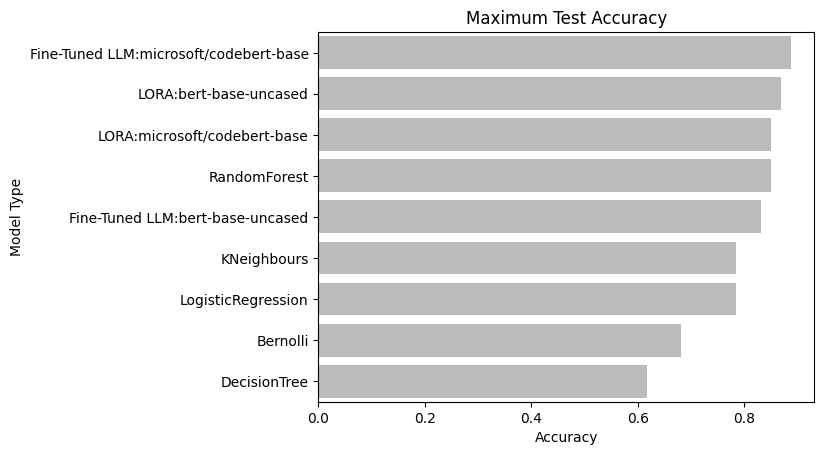

In [175]:
acc = sns.barplot(grouped_df[['group', 'accuracy']].sort_values('accuracy', ascending=False), y='group', x='accuracy', color=grey)
acc.set(title='Maximum Test Accuracy', xlabel='Accuracy', ylabel='Model Type')
acc.get_figure().savefig('plots/accuracy.pdf', bbox_inches='tight')

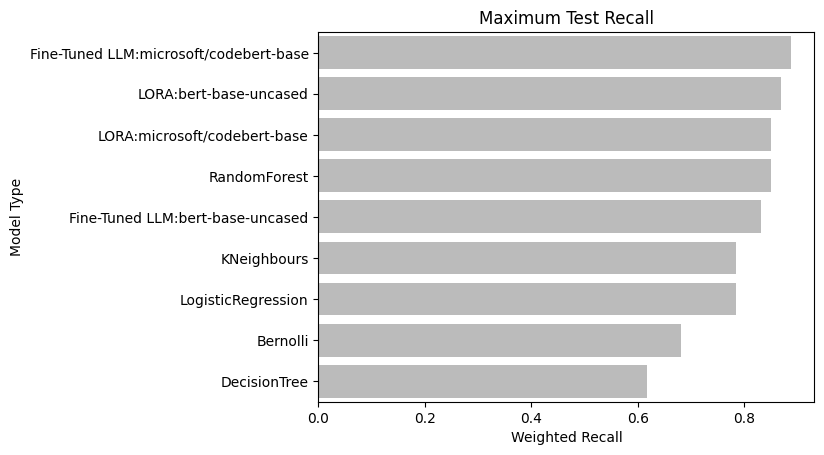

In [176]:
recall = sns.barplot(grouped_df[['group', 'recall_weighted']].sort_values('recall_weighted', ascending=False), y='group', x='recall_weighted', color=grey)
recall.set(title='Maximum Test Recall', xlabel='Weighted Recall', ylabel='Model Type')
recall.get_figure().savefig('plots/recall.pdf', bbox_inches='tight')

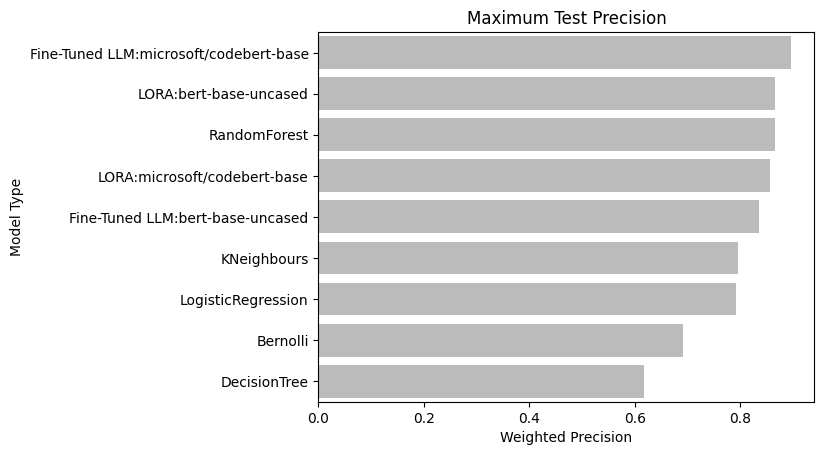

In [177]:
precision = sns.barplot(grouped_df[['group', 'precision_weighted']].sort_values('precision_weighted', ascending=False), y='group', x='precision_weighted', color=grey)
precision.set(title='Maximum Test Precision', xlabel='Weighted Precision', ylabel='Model Type')
precision.get_figure().savefig('plots/precision.pdf', bbox_inches='tight')

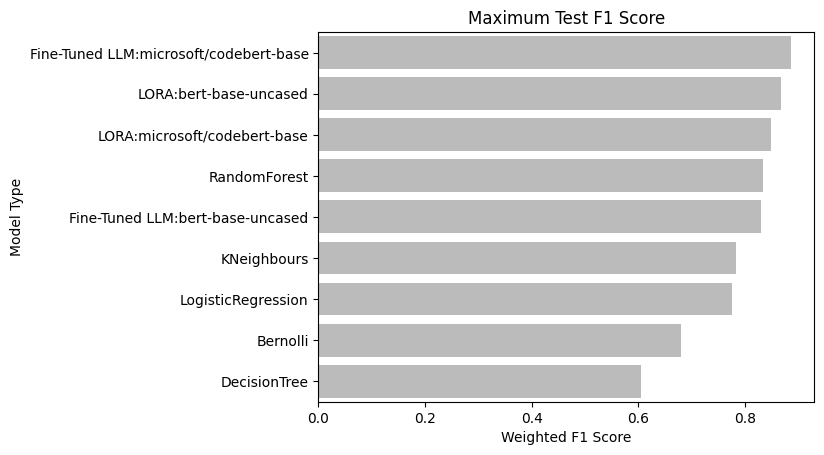

In [178]:
f1 = sns.barplot(grouped_df[['group', 'f1_weighted']].sort_values('f1_weighted', ascending=False), y='group', x='f1_weighted', color=grey)
f1.set(title='Maximum Test F1 Score', xlabel='Weighted F1 Score', ylabel='Model Type')
f1.get_figure().savefig('plots/f1.pdf', bbox_inches='tight')

In [179]:
grouped_df_melted = grouped_df.melt(id_vars=['group'])
grouped_df_melted['variable'] = grouped_df_melted['variable'].map(lambda metric_name: metric_name.title().replace('_Weighted', ''))
grouped_df_melted

,group,variable,value
0,Bernolli,Accuracy,0.682243
1,DecisionTree,Accuracy,0.616822
2,Fine-Tuned LLM:bert-base-uncased,Accuracy,0.831776
3,Fine-Tuned LLM:microsoft/codebert-base,Accuracy,0.887850
4,KNeighbours,Accuracy,0.785047
5,LORA:bert-base-uncased,Accuracy,0.869159
6,LORA:microsoft/codebert-base,Accuracy,0.850467
7,LogisticRegression,Accuracy,0.785047
8,RandomForest,Accuracy,0.850467
9,Bernolli,Precision,0.692127


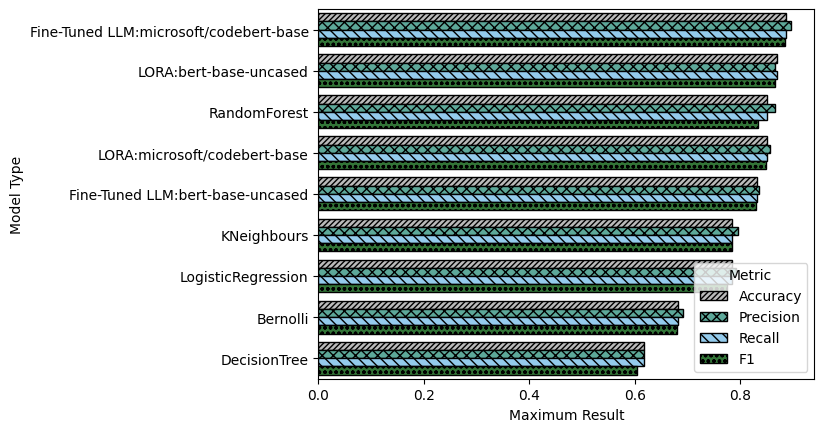

In [180]:
metrics = sns.barplot(grouped_df_melted.sort_values(['value'], ascending=False), y='group', x='value', hue='variable', hue_order=['Accuracy', 'Precision', 'Recall', 'F1'])


hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, metrics.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

metrics.set(xlabel='Maximum Result', ylabel='Model Type')
metrics.legend(title='Metric')

metrics.get_figure().savefig('plots/metric_results.pdf', bbox_inches='tight')

### Top results

In [181]:
top_df = df.sort_values(['test/accuracy'], ascending=False).head(100).reset_index()[['name','group', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted', 'config', 'tag']]
top_df

,name,group,test/accuracy,test/precision_weighted,test/recall_weighted,test/f1_weighted,config,tag
0,earnest-sun-1353,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
1,fragrant-bee-1348,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
2,golden-terrain-1356,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
3,laced-paper-1355,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
4,azure-pine-1352,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
...,...,...,...,...,...,...,...,...
95,major-grass-782,RandomForest,0.738318,0.765260,0.738318,0.741563,"{'rf_max_depth': 22, 'trial.number': 18}","['BoW', 'preprocessed']"
96,stilted-dragon-738,RandomForest,0.738318,0.749731,0.738318,0.740057,"{'rf_max_depth': 30, 'trial.number': 3}","['TfIdf', 'preprocessed']"
97,neat-darkness-1162,RandomForest,0.738318,0.750225,0.738318,0.725211,"{'rf_max_depth': 32, 'trial.number': 22}","['pre-trained:bert-base-uncased', 'preprocessed']"
98,curious-bush-1063,RandomForest,0.738318,0.744426,0.738318,0.723663,"{'rf_max_depth': 26, 'trial.number': 7}","['pre-trained:bert-base-uncased', 'preprocessed']"


## Runtime Evalation

In [182]:
runtime_df = df[['group', '_runtime']]
runtime_df.columns = ['group', 'runtime']
runtime_df['timedelta'] = pd.to_timedelta(runtime_df['runtime'], unit='s')

runtime_df.head()


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91734/3622652944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_df['timedelta'] = pd.to_timedelta(runtime_df['runtime'], unit='s')


,group,runtime,timedelta
0,LORA:microsoft/codebert-base,8241.924456,0 days 02:17:21.924455643
1,LORA:microsoft/codebert-base,863.039526,0 days 00:14:23.039526463
2,LORA:microsoft/codebert-base,8241.350571,0 days 02:17:21.350570917
3,LORA:microsoft/codebert-base,830.154019,0 days 00:13:50.154018879
4,LORA:microsoft/codebert-base,831.463608,0 days 00:13:51.463608265


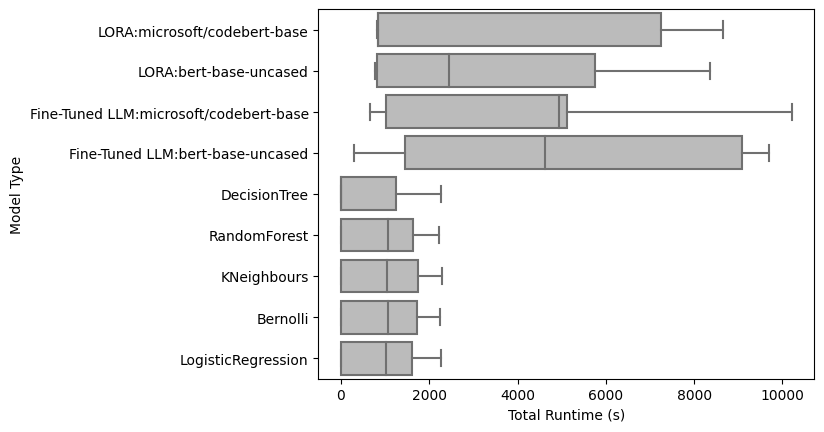

In [183]:
# TODO: Figure out how to change xaxis ticks

runtime = sns.boxplot(runtime_df, y='group', x='runtime', color=grey)
runtime.set(xlabel='Total Runtime (s)', ylabel='Model Type')

runtime.get_figure().savefig('plots/runtime.pdf', bbox_inches='tight')

In [198]:
avg_runtime = runtime_df.groupby('group').mean().reset_index().sort_values('runtime', ascending=False)
avg_runtime

,group,runtime,timedelta
2,Fine-Tuned LLM:bert-base-uncased,5022.890648,0 days 01:23:42.890647869
3,Fine-Tuned LLM:microsoft/codebert-base,4286.942240,0 days 01:11:26.942239619
5,LORA:bert-base-uncased,3479.064764,0 days 00:57:59.064763546
6,LORA:microsoft/codebert-base,3438.159201,0 days 00:57:18.159201312
7,LogisticRegression,936.050613,0 days 00:15:36.050612545
4,KNeighbours,932.702654,0 days 00:15:32.702654175
0,Bernolli,932.263378,0 days 00:15:32.263377919
8,RandomForest,907.647324,0 days 00:15:07.647323822
1,DecisionTree,667.236850,0 days 00:11:07.236849503


## Oversampling Plot

In [184]:
raw_df = pd.read_csv('data/raw.csv')
proc_df = pd.read_csv('data/proc.csv')

raw_df.head()

,func_code_string,label,query,text
0,public static HtmlPage toHtmlPage(String strin...,3,how to get html of website,how to get html of website<CODESPLIT>public st...
1,public static HtmlPage toHtmlPage(WebDriver we...,3,how to get html of website,how to get html of website<CODESPLIT>public st...
2,public static String reverse(String string) {\...,3,how to reverse a string,how to reverse a string<CODESPLIT>public stati...
3,public HtmlElement findHtmlElementById(String ...,2,reading element from html - <td>,reading element from html - <td><CODESPLIT>pub...
4,@NonNull\n public static String getNowDateT...,3,how to get current date,how to get current date<CODESPLIT>@NonNull ...


In [185]:
raw_df['source'] = 'Raw Data'
raw_df = raw_df[['source', 'label']]

raw_df.head()

,source,label
0,Raw Data,3
1,Raw Data,3
2,Raw Data,3
3,Raw Data,2
4,Raw Data,3


<Axes: xlabel='label', ylabel='count'>

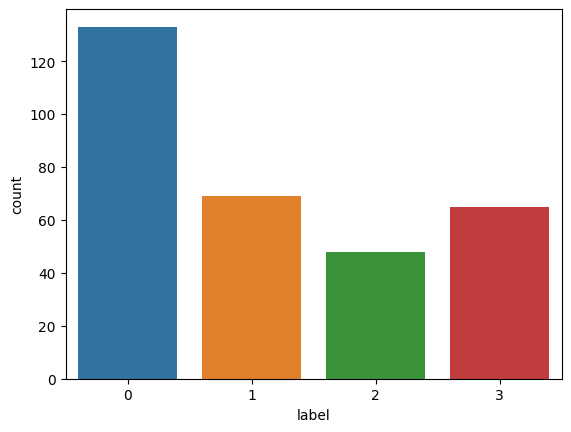

In [186]:
sns.countplot(raw_df, x='label')

In [187]:
proc_df['source'] = 'Oversampled Data'
proc_df = proc_df[['source', 'label']]

proc_df.head()

,source,label
0,Oversampled Data,0
1,Oversampled Data,1
2,Oversampled Data,2
3,Oversampled Data,3
4,Oversampled Data,0


<Axes: xlabel='label', ylabel='count'>

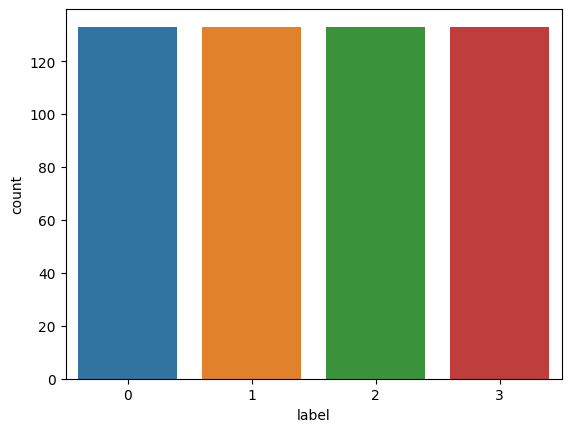

In [188]:
sns.countplot(proc_df, x='label')

In [189]:
count_df = pd.concat([raw_df, proc_df])
count_df.head()

,source,label
0,Raw Data,3
1,Raw Data,3
2,Raw Data,3
3,Raw Data,2
4,Raw Data,3


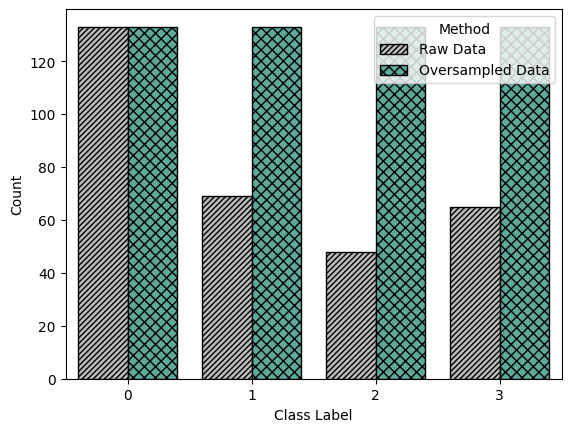

In [190]:
data_plt = sns.countplot(count_df, x='label', hue='source')

hatches = ['//', 'x']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, data_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

data_plt.set(xlabel='Class Label', ylabel='Count')
data_plt.legend(title='Method')

data_plt.get_figure().savefig('plots/oversampled.pdf', bbox_inches='tight')